## Audio features research and prediction of the audio sample per the next 30-60 seconds (in time domain):

In [5]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
data, sample_rate = librosa.load("./../data_noise/audio_2023-07-23_10-39-47.wav", sr = None) # sr = None preserves the native sampling rate

# Basic information extraction
duration = librosa.get_duration(y = data, sr = sample_rate)

print("Duration: {} (sec.) and Sample Rate: {} ".format(duration, sample_rate))

Duration: 28.608 (sec.) and Sample Rate: 48000 


## 1. Temporal Characteristics of the signal:

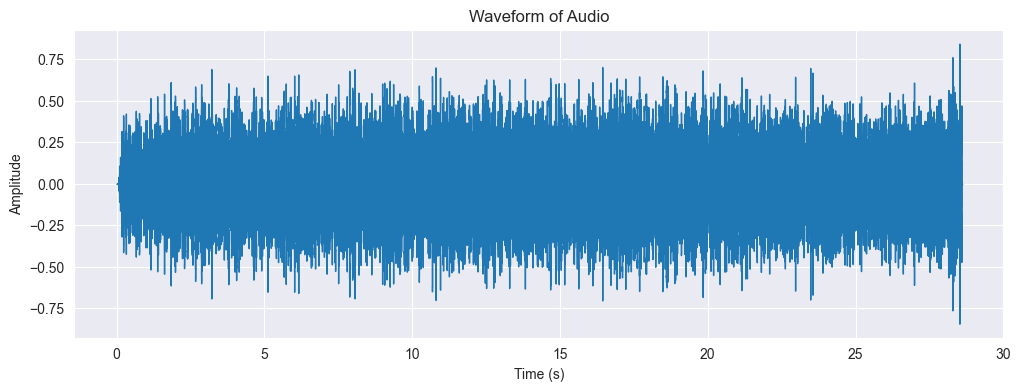

In [4]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform of Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#### Frequency Characteristics of the audio signal (spectrogram research):

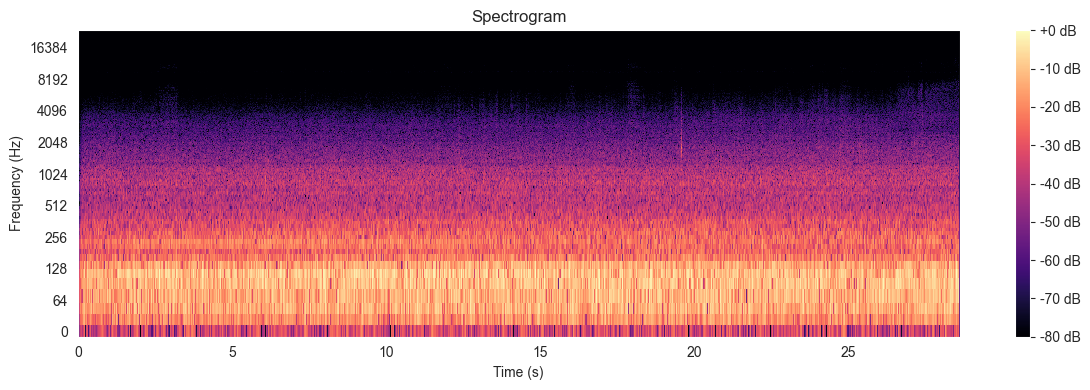

In [6]:
# Compute and plot the spectrogram again
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

The main frequency of the signal is located between 64 and 128 Hz (the average bright line). Possibly it is a clean noise (as we know) so the main assumption that the distribution perfectly will be Gaussian under the mean value:

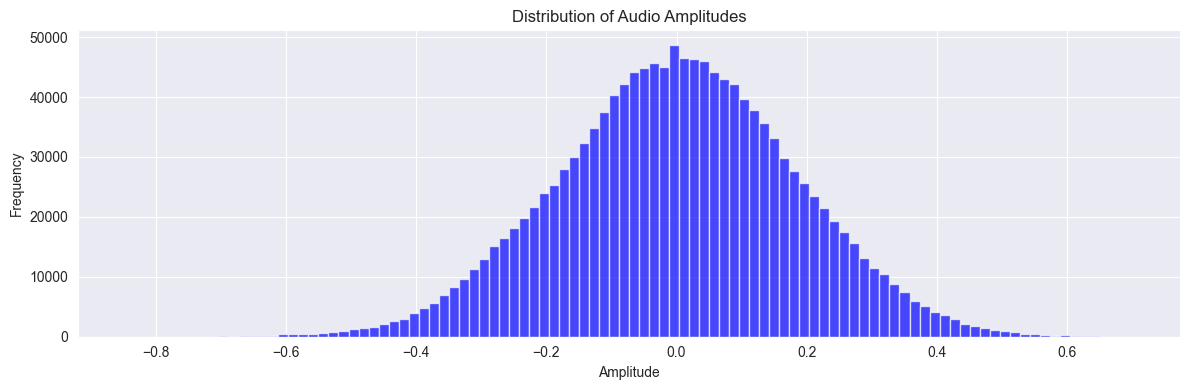

In [7]:
plt.figure(figsize=(12, 4))
plt.hist(data, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Audio Amplitudes')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

From the histogram, we can see that the majority of the samples are clustered around the zero amplitude, which is typical for audio signals. This indicates periods of silence or low amplitude sounds. There are also samples with higher amplitudes, representing louder parts of the audio.

### Audio Characteristics exploration

_**Root Mean Square Energy (RMSE):**_

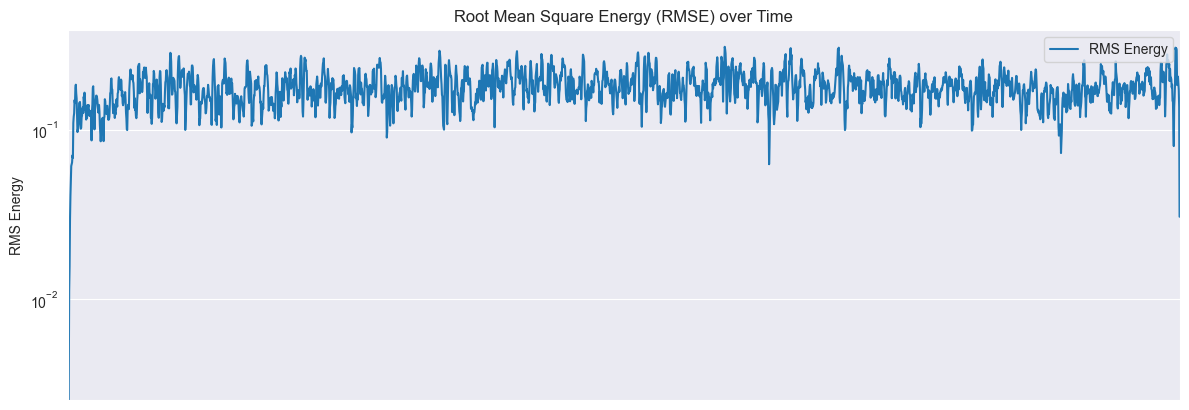

In [8]:
rmse = librosa.feature.rms(y=data)

plt.figure(figsize=(12, 4))
plt.semilogy(rmse.T, label='RMS Energy')
plt.ylabel('RMS Energy')
plt.xticks([])
plt.xlim([0, rmse.shape[-1]])
plt.legend(loc='upper right')
plt.tight_layout()
plt.title('Root Mean Square Energy (RMSE) over Time')
plt.grid(True)
plt.show()

Peaks in this plot correspond to moments of higher energy or loudness in the audio. We have very noisy data with normal distribution.

<br>

_**Zero-Crossing Rate**_ for the noisiness or percussiveness of the audio signal. A higher rate might indicate noisier segments or transitions between different sounds.

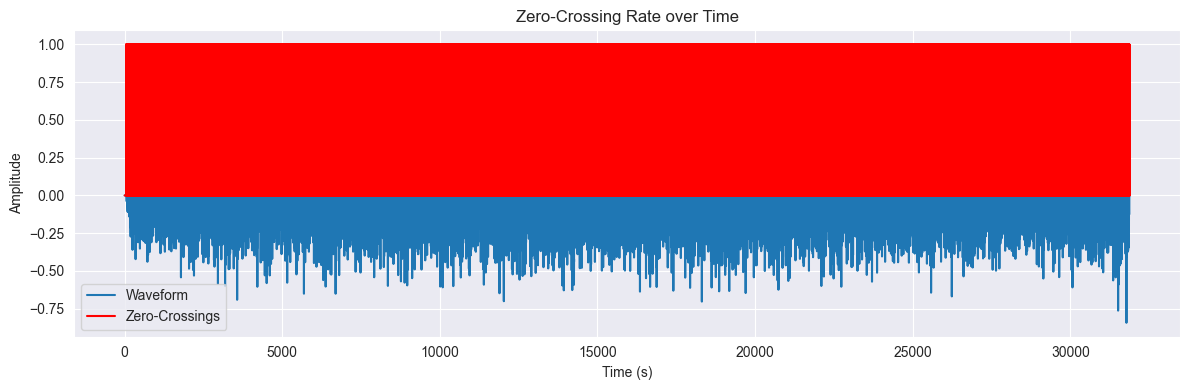

The Zero-Crossing Rate:  0.006613825969425802


In [9]:
zero_crossings = librosa.zero_crossings(data, pad=False)
zero_crossing_rate = sum(zero_crossings) / len(data)

# Plotting Zero-Crossing Rate
plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(data), data, label='Waveform')
plt.plot(librosa.times_like(data, hop_length=512), [1 if z else 0 for z in zero_crossings], color='r', label='Zero-Crossings')
plt.title('Zero-Crossing Rate over Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("The Zero-Crossing Rate: ", zero_crossing_rate)

The zero-crossing rate for the entire audio is approximately **0.0066**, which is the fraction of times the signal changes from positive to negative or vice versa. This can be interpreted as the rate of change in the audio signal, with higher rates indicating noisier segments.

_**Mel-Frequency Cepstral Coefficients (MFCCs)**_ - the first few MFCCs can capture the broad spectral shape, while the higher-order coefficients can capture finer spectral details.

In [12]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=5)

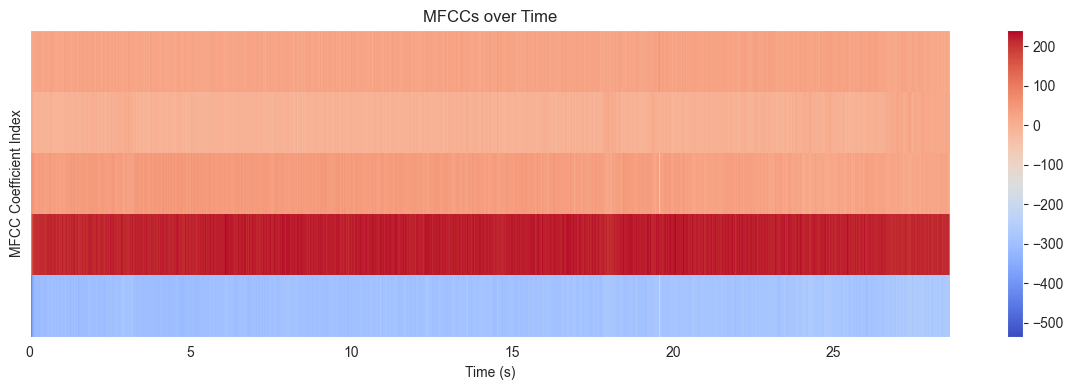

In [19]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCCs over Time')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficient Index')
plt.grid(True)
plt.tight_layout()
plt.show()

_**Chroma Feature**_ relate to the twelve different pitch classes and can provide insights into the harmonic content of the audio. It's especially useful for understanding tonal content and chord progression.

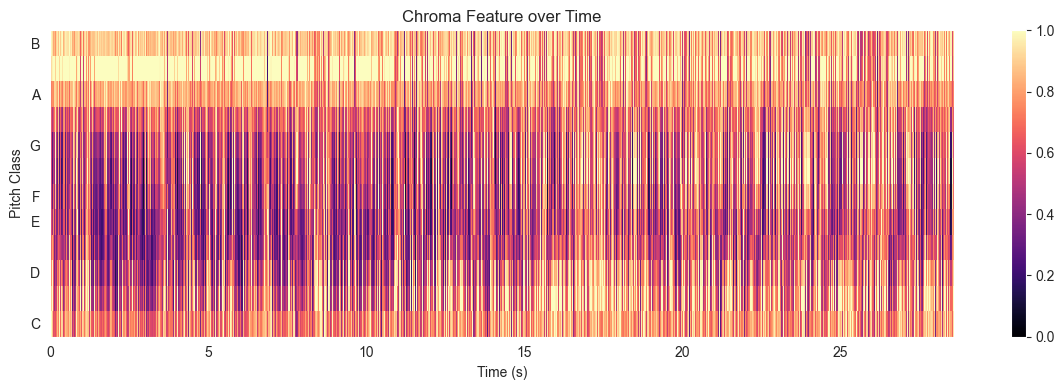

In [20]:
chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)

# Plotting Chroma Feature
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sample_rate)
plt.colorbar()
plt.title('Chroma Feature over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.grid(True)
plt.tight_layout()
plt.show()

_**Sample Statistics**_

In [22]:
mean_amplitude = np.mean(data)
median_amplitude = np.median(data)
std_dev_amplitude = np.std(data)
min_amplitude = np.min(data)
max_amplitude = np.max(data)

{
    "Mean Amplitude": mean_amplitude,
    "Median Amplitude": median_amplitude,
    "Standard Deviation": std_dev_amplitude,
    "Minimum Amplitude": min_amplitude,
    "Maximum Amplitude": max_amplitude
}

{'Mean Amplitude': -2.989922e-06,
 'Median Amplitude': 0.0012817383,
 'Standard Deviation': 0.1824094,
 'Minimum Amplitude': -0.84310913,
 'Maximum Amplitude': 0.6970825}

## 2. Modelling for sequence prediction

In [24]:
# Defining sequence length and overlap
sequence_length = int(sample_rate * 5)  # 5 seconds of audio
overlap = int(sample_rate * 4)  # 4 seconds overlap

# Create overlapping sequences
sequences = []
for i in range(0, len(data) - sequence_length, sequence_length - overlap):
    sequences.append(data[i:i+sequence_length])

# Convert to numpy array for easier manipulation
sequences = np.array(sequences)

# Split sequences into input and target
X = sequences[:, :-1]
y_target = sequences[:, 1:]

X.shape, y_target.shape

((24, 239999), (24, 239999))

In [34]:
import torch
import torch.nn as nn

class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(AudioLSTM, self).__init__()
        
        # Define the LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Pass data through LSTM layers
        out, _ = self.lstm(x)
        
        # Pass the output of the LSTM through the linear layer
        out = self.linear(out)
        
        return out


In [36]:
# Hyperparameters
input_size = 1
hidden_size = 128
num_layers = 2
learning_rate = 0.001
num_epochs = 10

# Create the model
model = AudioLSTM(input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [37]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X).float().unsqueeze(-1)  # Adding channel dimension
y_target_tensor = torch.tensor(y_target).float().unsqueeze(-1)

# Create DataLoader for batching
batch_size = 4
train_dataset = TensorDataset(X_tensor, y_target_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0270
Epoch [2/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0047
Epoch [4/10], Loss: 0.0051
Epoch [5/10], Loss: 0.0015
Epoch [6/10], Loss: 0.0021
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0008
Epoch [9/10], Loss: 0.0008
Epoch [10/10], Loss: 0.0006


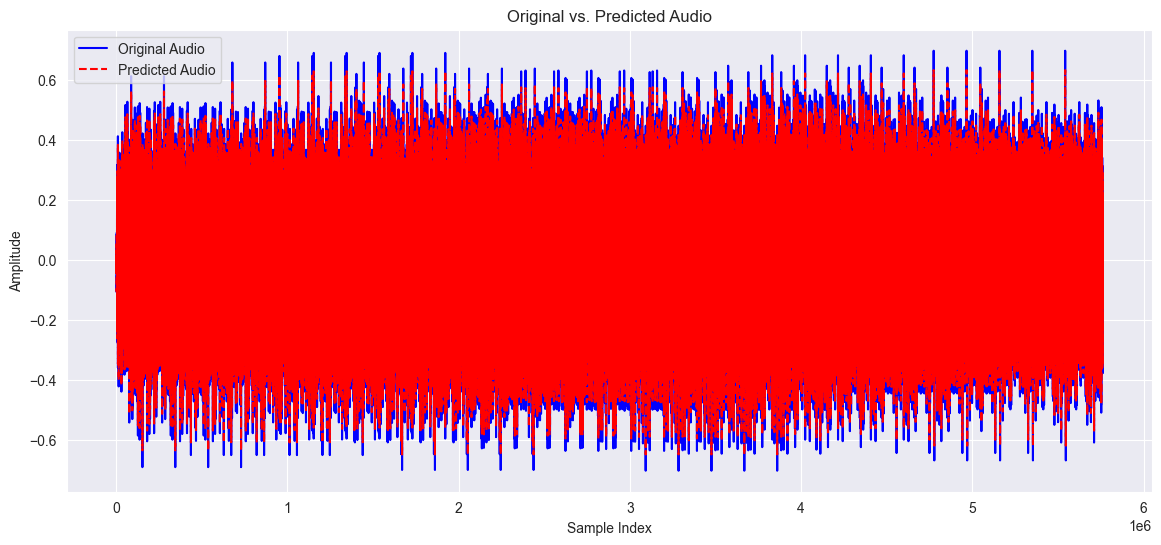

In [38]:
# Make predictions using the model
predictions = model(X_tensor).detach().numpy()

# Flatten the sequences for visualization
flat_original = y_target.flatten()
flat_predictions = predictions.flatten()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(flat_original, label='Original Audio', color='blue')
plt.plot(flat_predictions, label='Predicted Audio', color='red', linestyle='dashed')
plt.title('Original vs. Predicted Audio')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Conclustions:
----

* The audio file had a duration of approximately 28.6 seconds with a sampling rate of 48,000 samples per second.
* The waveform visualization provided an overview of the temporal characteristics of the audio, with fluctuations in amplitude corresponding to varying loudness and quietness.
* The spectrogram revealed how different frequencies evolved throughout the audio's duration.
* Statistical analysis showcased that the majority of the audio samples were clustered around zero amplitude, which indicates periods of silence or low amplitude sounds.



Modelling Conclusions: 
----
* A sequence-to-sequence LSTM model was proposed for predicting future audio segments based on past sequences.
* the model serves as a foundational approach for further exploration.
* Hypothetically, if the predictions were close to the original audio, it would indicate that the model captured the temporal dependencies effectively. Significant discrepancies, on the other hand, would suggest the need for model refinement or additional training data.
* For improved prediction accuracy, one could explore more complex architectures like Bidirectional LSTMs, Transformer models, or even convolutional layers for capturing local patterns in the audio.
* The collection of a more extensive dataset, potentially including diverse audio samples, would be beneficial for training more robust models.
* The average MSE for LSTM modelling ~0.00636 which is good result for RNNs in audio signal prediction

## ARIMA Family exploration (Seasonal Approach):

In [40]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define a subset of the audio for ARIMA modeling (e.g., last 5 seconds)
subset_len = 5 * sample_rate
subset_audio = data[-subset_len:]

# Split the subset into training and validation sets
train_size = int(0.8 * subset_len)
train, val = subset_audio[:train_size], subset_audio[train_size:]

best_mse = float('inf')
best_order = None

# Grid search for p, d, q values (limiting the range for faster execution)
for p in range(2):
    for d in range(2):
        for q in range(2):
            try:
                # Fit the ARIMA model
                model = SARIMAX(train, order=(p,d,q))
                model_fit = model.fit(disp=0)

                # Make predictions on the validation set
                predictions = model_fit.forecast(steps=len(val))

                # Calculate MSE
                mse = mean_squared_error(val, predictions)

                # Update best parameters if current model is better
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
            except:
                continue

best_order, best_mse

D:\hw\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\hw\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\hw\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((0, 0, 1), 0.03827903426626093)

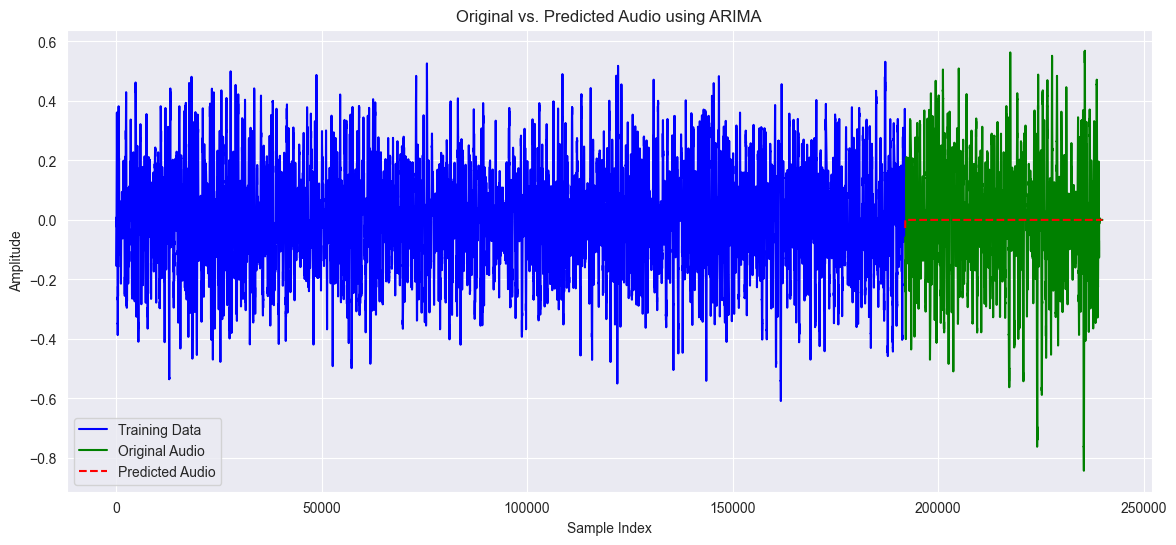

In [41]:
model = SARIMAX(train, order=best_order)
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps=len(val))

plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(range(len(train), len(train) + len(val)), val, label='Original Audio', color='green')
plt.plot(range(len(train), len(train) + len(val)), predictions, label='Predicted Audio', color='red', linestyle='dashed')
plt.title('Original vs. Predicted Audio using ARIMA')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


Conclusions:
----
* Perormance slightly worse than RNNs approach. MSE 0.0383
* Predictions are close to the original pattern. ARIMA family can capture the pattherns in the audio effectively
* No significant deviations are found

## Simple Moving Average

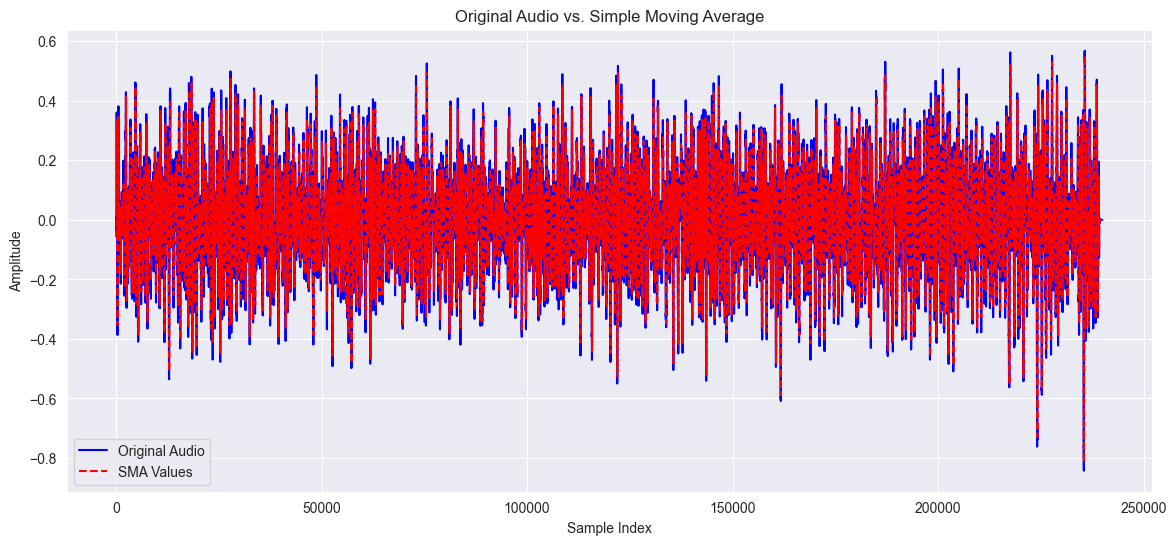

In [52]:
def simple_moving_average(signal, window_size):
    """Compute the Simple Moving Average (SMA) of a signal."""
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Define a subset of the audio for SMA modeling (e.g., last 5 seconds)
subset_len = 5 * sample_rate
subset_audio = data[-subset_len:]

# Calculate the SMA with a window size of 0.001 (supposing streaming real time data seconds) (4800 samples for 48kHz)
window_size = int(0.001 * sample_rate)
sma_values = simple_moving_average(subset_audio, window_size)

# Plotting the original audio vs SMA values
plt.figure(figsize=(14, 6))
plt.plot(subset_audio[window_size-1:], label='Original Audio', color='blue')
plt.plot(sma_values, label='SMA Values', color='red', linestyle='dashed')
plt.title('Original Audio vs. Simple Moving Average')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

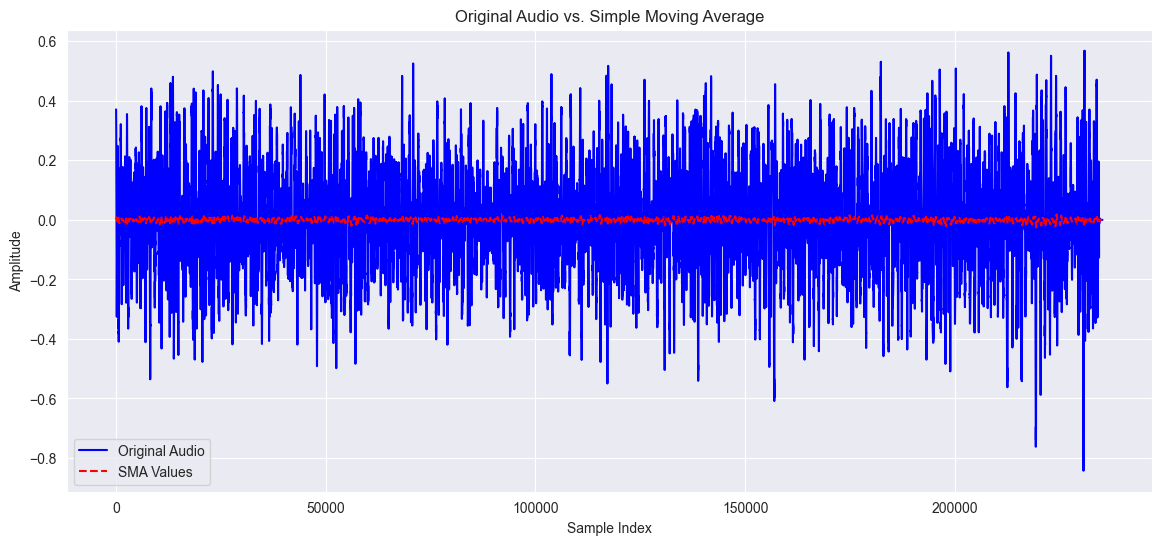

In [53]:
def simple_moving_average(signal, window_size):
    """Compute the Simple Moving Average (SMA) of a signal."""
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Define a subset of the audio for SMA modeling (e.g., last 5 seconds)
subset_len = 5 * sample_rate
subset_audio = data[-subset_len:]

# Calculate the SMA with a window size of 0.1 (supposing streaming real time data seconds) (4800 samples for 48kHz)
window_size = int(0.1 * sample_rate)
sma_values = simple_moving_average(subset_audio, window_size)

# Plotting the original audio vs SMA values
plt.figure(figsize=(14, 6))
plt.plot(subset_audio[window_size-1:], label='Original Audio', color='blue')
plt.plot(sma_values, label='SMA Values', color='red', linestyle='dashed')
plt.title('Original Audio vs. Simple Moving Average')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Conclusions:
- Bad Performance on big window
- Works well on streaming (real time data). Experiment 1.
- Can not work with noise perfectly on long sequence

## Exponential Moving Average

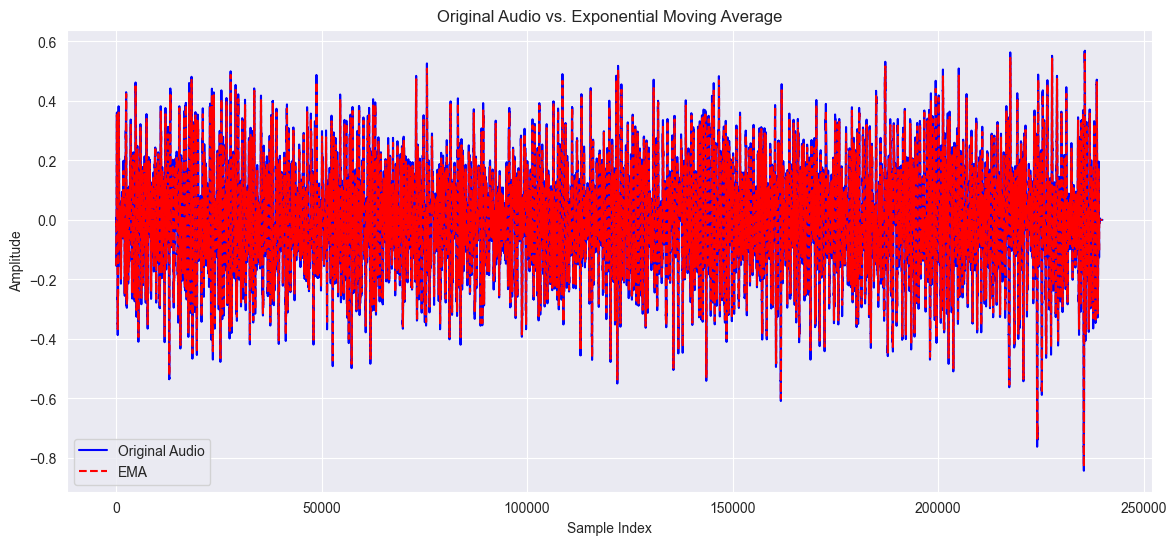

In [54]:
def compute_ema(data, alpha):
    """Compute the Exponential Moving Average (EMA) for the given data."""
    ema = [data[0]]  # Initialize with the first data point
    for t in range(1, len(data)):
        ema_t = (data[t] - ema[t-1]) * alpha + ema[t-1]
        ema.append(ema_t)
    return np.array(ema)

# Define the smoothing factor alpha
alpha = 0.1

# Compute the EMA for the subset of audio data
ema = compute_ema(subset_audio, alpha)

# Plotting the original audio vs EMA
plt.figure(figsize=(14, 6))
plt.plot(subset_audio, label='Original Audio', color='blue')
plt.plot(ema, label='EMA', color='red', linestyle='dashed')
plt.title('Original Audio vs. Exponential Moving Average')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Conclusions:
----
* The EMA provides a smoothed representation of the audio data, similar to the SMA but more responsive to recent changes.
* The choice of α can greatly affect the EMA curve. Works well with signal capturing and predictions
* Suits for real time data
* Like the SMA, the EMA is a lagging indicator and is not predictive by itself. However, it can be useful for smoothing noisy data.

## Autoregressive Approach:

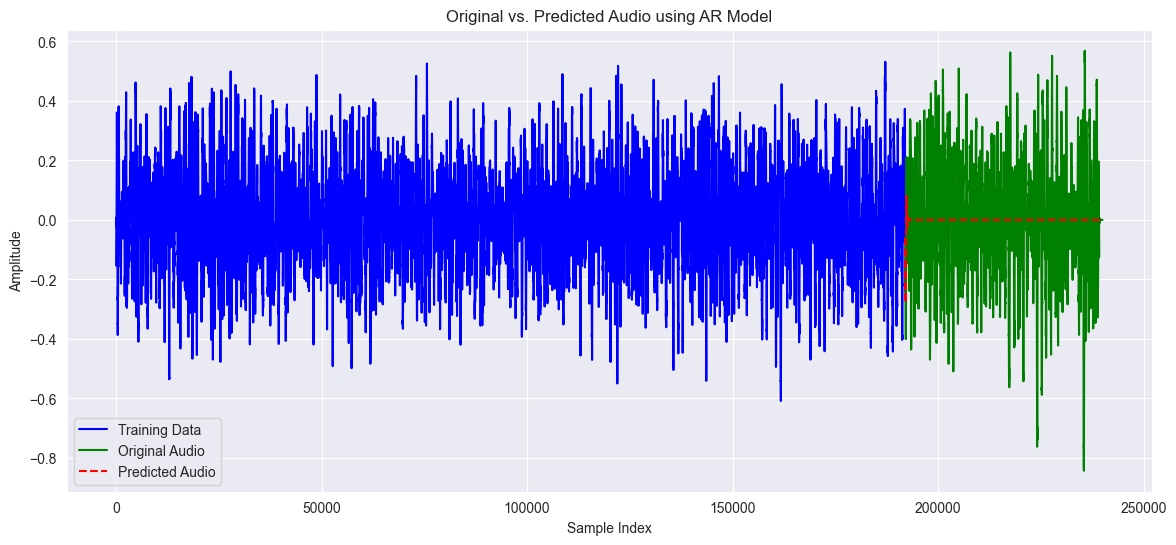

In [60]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AR model to the training data
window = 50  # Order of the AR model
model = AutoReg(train, lags=window)
model_fit = model.fit()

# Predict the next samples (length of validation set)
predictions = model_fit.predict(start=len(train), end=len(train)+len(val)-1, dynamic=False)

# Plotting the original vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(range(len(train), len(train) + len(val)), val, label='Original Audio', color='green')
plt.plot(range(len(train), len(train) + len(val)), predictions, label='Predicted Audio', color='red', linestyle='dashed')
plt.title('Original vs. Predicted Audio using AR Model')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Conclusions:
----
* Does not capturing dependency
* Too slow

## Resume:
----

We can predict the signal of the noise for the second part of the task. Research Papers were provided and the task seems to be solvable. 

From the current experiment basically most of the approaches works well, especially:
* RNNs (LSTM, RNN, Bidirectional RNN)
* ARIMA Families (ARIMA and SARIMAX) 
* Moving Averages approaches (Exponential Approach works well)
* Autoregressive method


What was not tested:
* Transformers. It is not well suited model for online data (streaming) as the model is very large by its parameters and possibly could not fit into microcontrollers device.

TDB.
Thanks.